In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xarray as xr
import datetime

from salishsea_tools import viz_tools

DFO data from 2013 - Mar 2020

PSF data from 2015 - 2017

PUG data from 2015 - 2018

ONC data from 2014 - 2022 

Ferry data from 2013 - 2022

CIOOS data from 2007 - 2023

In [2]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [3]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [4]:
with xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc') as mesh:
    deptht = mesh.gdept_1d[0].values
bathy = xr.open_dataset('/home/sallen/MEOPAR/grid/bathymetry_202108.nc')

In [5]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

In [6]:
def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

In [7]:
def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

In [8]:
def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())

In [9]:
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

In [10]:
def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

In [11]:
def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean()

In [12]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

In [13]:
def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
# bad onc data
 #   temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
  #  temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
  #                                   & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_nohook

In [14]:
def highlight_max_min(s):
    '''
    highlight the maximum in a Series lime green.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('limegreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

In [15]:
def plot_allyears(years, years_psf, years_pug, years_onc, years_ferry, years_cioos, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    startyear = min(years[0], years_psf[0], years_pug[0], years_cioos[0])#, years_onc[0])
    endyear = max(years[-1], years_psf[-1], years_pug[-1], years_cioos[-1])#, years_onc[-1])
    fig.suptitle(f'Year {startyear}-{endyear}')
    print (idepth, jdepth)
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv')
    for year in years_psf:
        pieces1.append(
            f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
         #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    for year in years_cioos:
        if (year == 2023):
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}1231.csv')    
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d201905, counts1 = plot_and_stats(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0], whichdepths, reverse, string)
    
    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_cioos:
        if (year == 2023):
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202111, counts2 = plot_and_stats(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[1], whichdepths, reverse, string)

    alltogether = pd.concat([d201905, d202111], axis=0)
    
    fig.savefig(f'{whichdepths}_{field}{string}_201905_202111_for_allyears.png')
    
    # f = open(f'./{whichdepths}_{field}{string}_201905_202111_for_allyears_table.tex', 'w')
    # f.write(alltogether.to_latex(column_format='lcccccccccc', 
    #         formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    # f.close()
    return alltogether, counts1, counts2

In [16]:
def stats_only(temp1, name, idepth, jdepth, corn, boxname):
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    number, tbias = bias(select, obsn, modn)
    if number > 0:
        trmse = rmse(select, obsn, modn)
        tcrmse = crmse(trmse, tbias)
        tswillmott = swillmott(select, obsn, modn)
        a1, b1, syst, nonsyst = wolfram_perp(select, obsn, modn)
        tspread = spread(select, obsn, modn)
        Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
          'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread,
          'region': boxname}
        dCp2 = pd.DataFrame(data=Cp2, index=[name])
    else:
        dCp2 = 0
    return number, dCp2

In [17]:
def stats_allregions(years, years_psf, years_pug, years_onc, years_ferry, years_cioos, idepth, jdepth, whichdepths):
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    for year in years_cioos:
        if (year == 2023):
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}1231.csv')    
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   
    temp1 = read_pieces(pieces1)
    
    number, alltogether = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, boxes[0], boxnames[0])
    for boxname, corn in zip(boxnames[1:], boxes[1:]):
        number, d201905 = stats_only(filter_bad_data(temp1), '201905R', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d201905], axis=0)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_cioos:
        if (year == 2023):
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
   
    for boxname, corn in zip(boxnames, boxes):
        number, d202111 = stats_only(filter_bad_data(temp2), '202111', idepth, jdepth, corn, boxname)
        if number > 0:
            alltogether = pd.concat([alltogether, d202111], axis=0)
    # f = open(f'./{whichdepths}_{field}_201905_202111_for_allregions_table.tex', 'w')
    # f.write(alltogether.to_latex(column_format='lccccccccccl', 
    #         formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, None]))
    # f.close()
    return alltogether

In [18]:
def plot_profiles(temp1, temp2, ax, ax2, box, boxname):

    corn = box
    temp1['diff'] = temp1[modn] - temp1[obsn]
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    kls = len(select.groupby('k')[obsn])
    ax.plot(select.groupby('k')[obsn].mean(), deptht[:kls], 'o-', c='tab:green', label='Observations')
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:blue', label='201905')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[:kls], '-', c='tab:blue', label='201905')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:blue')
    ax2.fill_betweenx(deptht[:kls], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:blue')
    ax.set_ylim(idepth,jdepth)  # try this lol
    ax2.set_ylim(idepth,jdepth)  # and this TODO figure out why wrong

    temp2['diff'] = temp2[modn] - temp2[obsn]
    select = temp2[(temp2.k >= idepth) & (temp2.k <= jdepth) &
                              (temp2.j >= corn[0]) & (temp2.j <= corn[1]) &
                              (temp2.i >= corn[2]) & (temp2.i <= corn[3])]
    
    ax.plot(select.groupby('k')[modn].mean(), deptht[:kls], 'o-', c='tab:orange', label='202111')
    ax2.plot(select.groupby('k')['diff'].mean(), deptht[:kls], '-', c='tab:orange', label='202111')
    ax.fill_betweenx(deptht[:kls], select[['k', modn]].groupby('k').quantile(q=0.25)[modn], select[['k', modn]].groupby('k').quantile(q=0.75)[modn], alpha=0.2, color='tab:orange')
    ax.fill_betweenx(deptht[:kls], select[['k', obsn]].groupby('k').quantile(q=0.25)[obsn], select[['k', obsn]].groupby('k').quantile(q=0.75)[obsn], alpha=0.2, color='tab:orange')
    ax2.fill_betweenx(deptht[:kls], select[['k', 'diff']].groupby('k').quantile(q=0.25)['diff'], select[['k', 'diff']].groupby('k').quantile(q=0.75)['diff'], alpha=0.2, color='tab:orange')
    
    ax.invert_yaxis()
    ax2.invert_yaxis()
    
    ax.legend()
    ax2.legend()
    ax.set_title(f'{field} Profiles')
    ax2.set_title(f'{field} Difference Profiles')
    ax2.grid();

In [19]:
def plot_box(ax, corn, colour):
    ax.plot([corn[2], corn[3], corn[3], corn[2], corn[2]], 
            [corn[0], corn[0], corn[1], corn[1], corn[0]], '-', color=colour)

## Me change

In [20]:
import salishsea_tools.river_202108 as rivers

In [21]:
def river_box(w_shed, r_call, box_side):  #TODO: change either box location or change box to circle
    river_idx = [rivers.prop_dict[w_shed][r_call]['i'], rivers.prop_dict[w_shed][r_call]['j']]
    river_range = [river_idx[0] - box_side, river_idx[0] + box_side, river_idx[1] - box_side, river_idx[1] + box_side]

    if (river_range[0] < 0):
        river_range[0] = 0
        river_range[1] = box_side*2

    if (898 - river_range[1] < 0):
        river_range[0] = 897-box_side*2
        river_range[1] = 897

    if (398 - river_range[3] < 0):
        river_range[2] = 398-box_side*2
        river_range[3] = 398

    return river_range

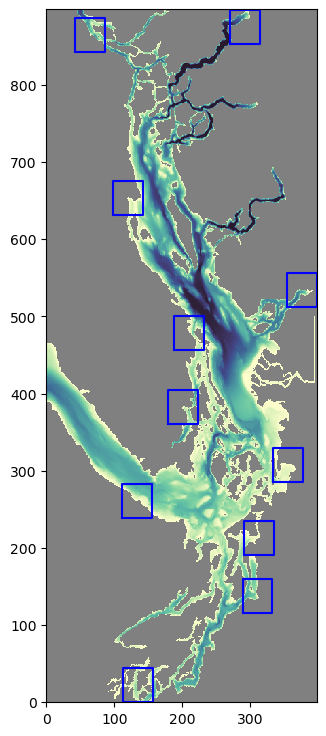

In [22]:
box_size = 22

fig, ax = plt.subplots(1, 1, figsize=(5, 9))
mycmap = cm.deep
mycmap.set_bad('grey')
ax.pcolormesh(bathy['Bathymetry'], cmap=mycmap)
viz_tools.set_aspect(ax);

# order (CW starting under the Fraser): Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish
Nooksack = river_box('fraser', 'Nooksack', box_size)
plot_box(ax, Nooksack, 'b')

Skagit = river_box('skagit', 'Skagit1', box_size)
plot_box(ax, Skagit, 'b')

Snohomish = river_box('skagit', 'SnohomishAllenQuilceda', box_size)
plot_box(ax, Snohomish, 'b')

Nisqually = river_box('puget', 'NisquallyMcAllister', box_size)
plot_box(ax, Nisqually, 'b')

Elwha = river_box('jdf', 'Elwha', box_size)
plot_box(ax, Elwha, 'b')

Cowichan = river_box('evi_s', 'Cowichan1', box_size)
plot_box(ax, Cowichan, 'b')

Nanaimo = river_box('evi_s', 'Nanaimo1', box_size)
plot_box(ax, Nanaimo, 'b')

Puntledge = river_box('evi_s', 'Puntledge', box_size)
plot_box(ax, Puntledge, 'b')

Salmon = river_box('evi_n', 'SalmonSayward', box_size)
plot_box(ax, Salmon, 'b')

Homathko = river_box('bute', 'Homathko', box_size)
plot_box(ax, Homathko, 'b')

Squamish = river_box('howe', 'Squamish', box_size)
plot_box(ax, Squamish, 'b')

boxes = [Nooksack, Skagit, Snohomish, Nisqually, Elwha, Cowichan, Nanaimo, Puntledge, Salmon, Homathko, Squamish]
boxnames = ['Nooksack', 'Skagit', 'Snohomish', 'Nisqually', 'Elwha', 'Cowichan', 'Nanaimo', 'Puntledge', 'Salmon', 'Homathko', 'Squamish']

# Fraser_plume = [380, 460, 260, 330]
# plot_box(ax, Fraser_plume, 'm')

## Stats

# Look deeper

In [23]:
def plot_and_stats_season(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    print (temp1[temp1.k <= idepth])
    if boxes:
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    # counts, xedges, yedges, color = ax.hist2d(select[one], 
    #                                           select[two], 
    #                                        bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    # fig.colorbar(color, ax=ax)
    counts = 'placeholder'

    # print(select)
    # ax.scatter(select[one], select[two], c=select['Month'])

    cmap = cm.phase
    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # force the first color entry to be grey
    # cmaplist[0] = (.5, .5, .5, 1.0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.linspace(1, 12, 13)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


    cb = ax.scatter(select[one], select[two], c=select['Month'], cmap=cmap, s=5, norm=norm)
    fig.colorbar(cb, ax=ax)

   
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

In [118]:
def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    temp1['Month'] = [int(utc[5:7]) for utc in temp1['dtUTC'].values]
    temp1['dtUTCfix'] = [utc[0:19] for utc in temp1['dtUTC'].values]
    # temp1['datetime'] = [pd.to_datetime(utc[0:19]) for utc in temp1['dtUTC'].values]
    temp1['datetime'] = [datetime.datetime.strptime(utc[0:19], '%Y-%m-%d %H:%M:%S') for utc in temp1['dtUTC'].values]

    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        # nextpiece['Month'] = [datetime.datetime.strptime(utc, '%Y-%m-%d %H:%M:%S').month for utc in nextpiece['dtUTC'].values]
        nextpiece['datetime'] = [datetime.datetime.strptime(utc[0:19], '%Y-%m-%d %H:%M:%S') for utc in nextpiece['dtUTC'].values]
        # nextpiece['datetime'] = [pd.to_datetime(utc[0:19]) for utc in nextpiece['dtUTC'].values]
        nextpiece['dtUTCfix'] = [utc[0:19] for utc in nextpiece['dtUTC'].values]
        nextpiece['Month'] = [int(utc[5:7]) for utc in nextpiece['dtUTC'].values]
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

In [58]:
def stats_and_plot_season(years, years_psf, years_pug, years_onc, years_ferry, years_cioos, idepth, jdepth, box, boxname, whichdepths):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(f'{boxname} Year {years_cioos[0]}-{years_cioos[-1]}')
    
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv') 
    for year in years_cioos:
        if (year == 2023):
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces1.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}1231.csv')    
    for year in years_ferry:
        pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   
    temp1 = read_pieces(pieces1)

    
    
    alltogether, counts = plot_and_stats_season(filter_bad_data(temp1), '201905R', idepth, jdepth, fig, axs[0], whichdepths, False, '', boxes=True, box=box, boxname=boxname)

    pieces2 = []
    for year in years:
        pieces2.append(
              f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ctd_{year}0101_{year}1231.csv'
             )
    for year in years_psf:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_psfts_{year}0101_{year}1231.csv')
    for year in years_pug:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_pugts_{year}0101_{year}1231.csv')
    for year in years_onc:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_onc_{year}0101_{year}1231.csv')
    for year in years_cioos:
        if (year == 2023):
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}0805.csv')
        else: 
            pieces2.append(
                f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    for year in years_ferry:
        pieces2.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_202111_ferry_{year}0101_{year}1231.csv')
    temp2 = read_pieces(pieces2)
    d202111, counts = plot_and_stats_season(filter_bad_data(temp2), '202111', idepth, jdepth, fig, axs[1], whichdepths, False, '', boxes=True, box=box, boxname=boxname)
    
    plot_profiles(temp1, temp2, axs[2], axs[3], box, boxname)
    
    
    alltogether = pd.concat([alltogether, d202111], axis=0)

In [28]:
# idepth = 0
# jdepth = 10
# region = 'Skagit'

# # results = stats_allregions([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020, 2021], 
# #                            [2015, 2016, 2017, 2018, 2019], [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
# #                            idepth, jdepth, 'test')

# # print(f'\033[1m{region}\033[1m')
# # display(results[results.region == region].loc[:, results.columns != 'region'].style.format(myformat).apply(highlight_max_min))

# stats_and_plot_season([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], [2015, 2016, 2017], [2015, 2016, 2017, 2018], [2015, 2016, 2017, 2018, 2019, 2020], 
#                [2015, 2016, 2017, 2018, 2019], [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
#                idepth, jdepth, Skagit, region, 'top30m')

In [119]:
idepth = 0
jdepth = 10
region = 'Skagit'

years= [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]
years_psf = [2015, 2016, 2017]
years_pug = [2015, 2016, 2017, 2018]
years_onc = [2015, 2016, 2017, 2018, 2019, 2020]
years_ferry = [2015, 2016, 2017, 2018, 2019]
years_cioos = [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
box = Skagit
boxname = region
whichdepths = 'top30m'    

pieces1 = []
for year in years:
    pieces1.append(
            f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ctd_{year}0101_{year}1231.csv'
            )  # Year, Month, Day
for year in years_psf:
    pieces1.append(
        f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')  # 'dtUTC'
for year in years_pug:
    pieces1.append(
        f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')  # 'dtUTC'
for year in years_onc:
    pieces1.append(
        f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')  # 'dtUTC'
for year in years_cioos:
    if (year == 2023):
        pieces1.append(
            f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}0805.csv')  # 'dtUTC'
    else: 
        pieces1.append(
            f'/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/model_obs_eval/ObsModel_201905R_CIOOS_{year}0101_{year}1231.csv')    
for year in years_ferry:
    pieces1.append(
        f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')   # 'dtUTC'
temp1 = read_pieces(pieces1)

In [62]:
reverse=False
boxes=True

if boxes:
    corn = box
    select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                            (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                            (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
    shift_text = 0.94
else:
    select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
    shift_text = 1

print (swillmott(select, 'SA', 'mod_vosaline'))

if reverse:
    one = modn
    two = obsn
else:
    one = obsn
    two = modn

select

0.2130702198215445


,Unnamed: 0,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,...,TEMPS901,SA.1,chlorophyll (ug/l),turbidity (NTU),o2_concentration_corrected (ml/l),oxygen (uM),indf_ptrc_T,ih_ptrc_T,indf_grid_T,ih_grid_T
1382838,3480,NaN,1.0,NaN,NaN,48.296488,-122.489605,1.0,18.065027,7.979422,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1382839,3481,NaN,1.0,NaN,NaN,48.296488,-122.489605,1.5,19.898122,8.483985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1382840,3482,NaN,1.0,NaN,NaN,48.296488,-122.489605,2.0,20.315915,8.591076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1382841,3483,NaN,1.0,NaN,NaN,48.296488,-122.489605,2.5,20.451653,8.622203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1382842,3484,NaN,1.0,NaN,NaN,48.296488,-122.489605,3.0,20.649087,8.665399,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582442,50975,NaN,12.0,NaN,NaN,48.296488,-122.489605,9.0,27.925504,11.041421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1582443,50976,NaN,12.0,NaN,NaN,48.296488,-122.489605,9.5,28.155788,11.109521,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1582444,50977,NaN,12.0,NaN,NaN,48.296488,-122.489605,10.0,28.546544,11.220724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1582445,50978,NaN,12.0,NaN,NaN,48.296488,-122.489605,10.5,29.248703,11.414967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
temp1['dtUTCfix']

0          2013-01-10 17:07:05
1          2013-01-10 17:07:05
2          2013-01-10 17:07:05
3          2013-01-10 17:07:05
4          2013-01-10 17:07:05
                  ...         
2895422    2019-10-15 23:55:00
2895423    2019-10-15 23:56:00
2895424    2019-10-15 23:57:00
2895425    2019-10-15 23:58:00
2895426    2019-10-15 23:59:00
Name: dtUTCfix, Length: 2895427, dtype: object

In [121]:
temp1['datetime']

0         2013-01-10 17:07:05
1         2013-01-10 17:07:05
2         2013-01-10 17:07:05
3         2013-01-10 17:07:05
4         2013-01-10 17:07:05
                  ...        
2895422   2019-10-15 23:55:00
2895423   2019-10-15 23:56:00
2895424   2019-10-15 23:57:00
2895425   2019-10-15 23:58:00
2895426   2019-10-15 23:59:00
Name: datetime, Length: 2895427, dtype: datetime64[ns]

In [70]:
datetime.datetime.strptime(temp1['dtUTC'].values[0], '%Y-%m-%d %H:%M:%S')

datetime.datetime(2013, 1, 10, 17, 7, 5)

In [88]:
# list_oflen = [len(utc) for utc in temp1['dtUTC'].values]
# list_ofbool = [len(utc) != 19 for utc in temp1['dtUTC'].values]
# list_ofweird = temp1['dtUTC'][list_ofbool]
# list_ofbool2 = [len(utc) != 23 for utc in list_ofweird]
# np.count_nonzero(list_ofbool2)
# list_offix = [utc[0:19] for utc in temp1['dtUTC'].values]
# list_ofbool3 = [len(utc) != 19 for utc in list_offix]
# np.count_nonzero(list_ofbool3)

list_oflen = [len(utc) for utc in temp1['dtUTC'].values]
list_ofbool = [len(utc) != 19 for utc in temp1['dtUTC'].values]
list_ofweird = temp1['dtUTC'][list_ofbool]
list_ofbool2 = [len(utc) != 23 for utc in list_ofweird]
np.count_nonzero(list_ofbool2)
list_offix = [utc[0:19] for utc in temp1['dtUTC'].values]
list_ofbool3 = [len(utc) != 19 for utc in list_offix]
np.count_nonzero(list_ofbool3)

pd.to_datetime(temp1['dtUTC'][0])

1

In [56]:
temp1['dtUTC'].values

array(['2013-01-10 17:07:05', '2013-01-10 17:07:05',
       '2013-01-10 17:07:05', ..., '2019-10-15 23:57:00',
       '2019-10-15 23:58:00', '2019-10-15 23:59:00'], dtype=object)

In [55]:
dtimes = [datetime.datetime.strptime(utc[0:19], '%Y-%m-%d %H:%M:%S') for utc in temp1['dtUTC'].values]
dtimes

[datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.datetime(2013, 1, 10, 17, 7, 5),
 datetime.d

In [105]:
np.count_nonzero(np.isnat(temp1['datetime'].to_numpy()))

99943

In [106]:
len(temp1['datetime'].to_numpy())

2895427

In [31]:
np.count_nonzero(np.isnan(select['Month'].values))

760

In [32]:
select.groupby(by='k').count()

,Unnamed: 0,Year,Month,Day,Hour,Lat,Lon,Z,SA,CT,...,TEMPS901,SA.1,chlorophyll (ug/l),turbidity (NTU),o2_concentration_corrected (ml/l),oxygen (uM),indf_ptrc_T,ih_ptrc_T,indf_grid_T,ih_grid_T
k,,,,,,,,,,,,,,,,,,,,,
0,36,0,0,0,0,36,36,36,36,36,...,0,0,0,0,0,0,0,0,0,0
1,76,0,0,0,0,76,76,76,76,76,...,0,0,0,0,0,0,0,0,0,0
2,74,0,0,0,0,74,74,74,74,74,...,0,0,0,0,0,0,0,0,0,0
3,73,0,0,0,0,73,73,73,73,73,...,0,0,0,0,0,0,0,0,0,0
4,72,0,0,0,0,72,72,72,72,72,...,0,0,0,0,0,0,0,0,0,0
5,72,0,0,0,0,72,72,72,72,72,...,0,0,0,0,0,0,0,0,0,0
6,72,0,0,0,0,72,72,72,72,72,...,0,0,0,0,0,0,0,0,0,0
7,72,0,0,0,0,72,72,72,72,72,...,0,0,0,0,0,0,0,0,0,0
8,72,0,0,0,0,72,72,72,72,72,...,0,0,0,0,0,0,0,0,0,0


StopIteration: 

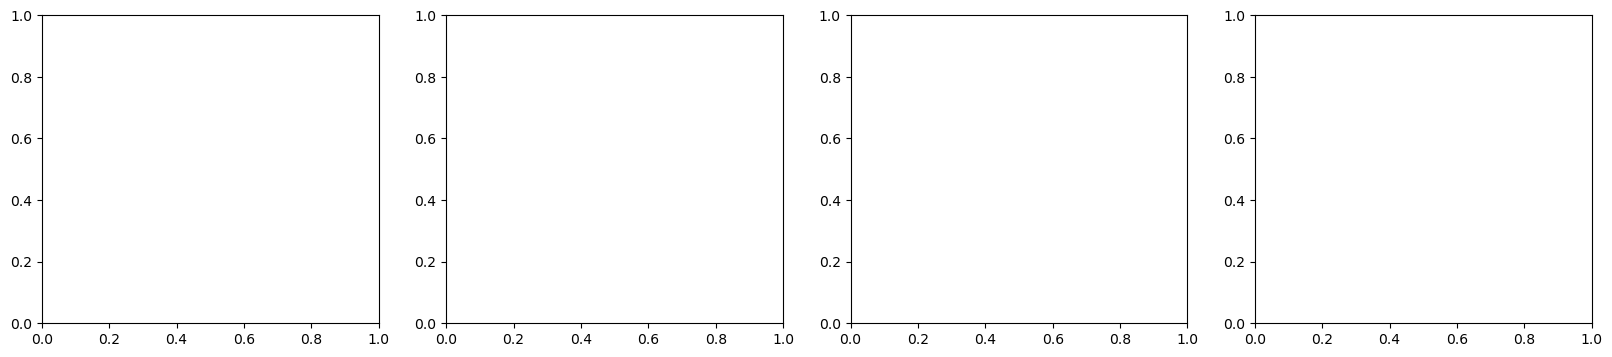

In [33]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

cmap = cm.phase
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
# cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(1, 12, 13)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)


cb = axs[0].scatter(select[one], select[two], c=select['Month'], s=5, cmap=cmap, norm=norm)
fig.colorbar(cb, ax=axs[0])
